In [1]:
# Strategy 1:
# Generate data after each epoch of training, if less than
# 10% error rate, and is a legit SMILES
# append to the real data
# Otherwise, append to fake data

# ADDING REINFORCEMENT MECHANISM
# Regenerate Normal sampling (define ranges), default: uniform

# IMPORTANT!!!!!!!!!!!!! DO NOT DROP DUPLICATE FOR RESULT .CSV

import warnings
warnings.filterwarnings('ignore')

import time
import os
import re
import pandas as pd
import random

import matplotlib as mpl
from matplotlib import rc, rcParams

import numpy as np
from numpy import ndarray

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from scipy.stats import truncnorm

import multiprocessing
import pickle


from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from   matplotlib.lines import Line2D
from   matplotlib.colors import ListedColormap
import matplotlib.ticker as tk
from scipy.stats import pearsonr

from progressbar import ProgressBar
import seaborn as sns

from chainer_chemistry.dataset.preprocessors import GGNNPreprocessor, construct_atomic_number_array
preprocessor = GGNNPreprocessor()
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
from rdkit import Chem

import ntpath
from scipy.stats import truncnorm

Text(0.5, 0, '!!!Ariaaaal')

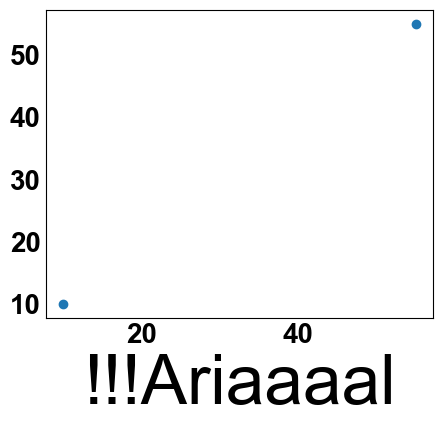

In [2]:
# check the font !!!!!!!!!!!!!!!!!!!!!
# switch to Arial
# if not working: delet ~/.catch/matplotlib
plt.rcParams["font.family"] = "Arial"
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.fonttype'] = 42
mpl.font_manager.FontManager()

rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter([10, 55], [10, 55])
ax.tick_params(axis='both', length=0, width=1.5, colors='black', grid_alpha=0, labelsize=20)
plt.xlabel('!!!Ariaaaal', fontname='Arial', fontsize=50)

In [3]:
with open('./../data/trainingsets/image.pickle', 'rb') as f:
    _, SMILES_original, y_original = pickle.load(f) 

initial_train = pd.read_csv (
    './../experiments/regular/regularVStransfer_gapdist/Initial_training.csv')
trans1 = pd.read_csv (
    './../experiments/regular/regularVStransfer_gapdist/transfer1.csv')
trans2 = pd.read_csv (
    './../experiments/regular/regularVStransfer_gapdist/transfer2.csv')

In [4]:
print (np.mean (initial_train['pred_gap']))
print (np.max (initial_train['pred_gap']))
print (np.mean(trans1['pred_gap']))
print (np.max(trans1['pred_gap']))
print (np.mean (trans2['pred_gap']))
print (np.max (trans2['pred_gap']))

6.338789432108744
10.2934065
7.420731576217765
10.507843
8.669230996165945
12.839399


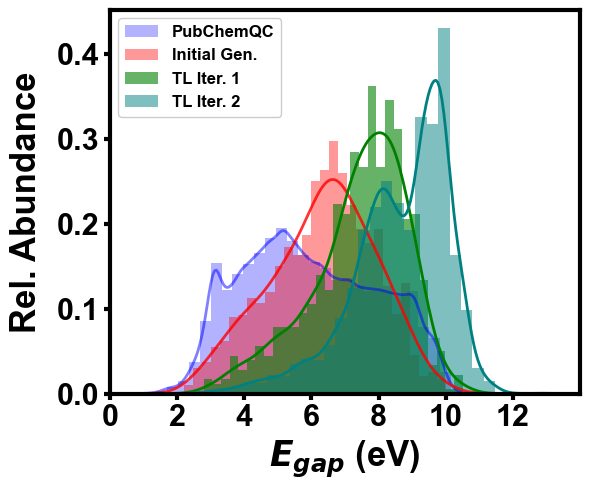

In [5]:
fig, ax = plt.subplots(figsize=(6, 5))

bw_adjust1 = 0.8
bw_adjust2 = 1.5
bw_adjust3 = 1
bw_adjust4 = 1

kwargs1 = dict(kde_kws={'bw_adjust':1})
kwargs2 = dict(kde_kws={'bw_adjust':1, 'bw_method':'silverman'})
kwargs3 = dict(kde_kws={'bw_adjust':1, 'bw_method':'silverman'})
kwargs4 = dict(kde_kws={'bw_adjust':2, 'bw_method':'silverman'})


sns1 = sns.histplot(y_original, color='blue', fill=True, label='PubChemQC', stat='density', **kwargs1,
             kde=False, bins=30, alpha=0.3, linewidth=0, )
sns.kdeplot(y_original, bw_adjust=bw_adjust1, color='blue', 
            fill=False, label='', linewidth=2, alpha=0.5)

sns.histplot(initial_train['pred_gap'], color='red', fill=True,  label='Initial Gen.', **kwargs2, alpha=0.4,
             kde=False, stat='density', bins=30, linewidth=0)
sns.kdeplot(initial_train['pred_gap'], bw_adjust=bw_adjust2, color='red', 
            fill=False, label='', linewidth=2, alpha=0.8)

sns.histplot(trans1['pred_gap'], color='green', fill=True, label='TL Iter. 1', stat='density', **kwargs3, alpha=0.6,
             kde=False, bins=30, linewidth=0)
sns.kdeplot(trans1['pred_gap'], bw_adjust=bw_adjust3, color='green', 
            fill=False, label='', linewidth=2, alpha=1)

sns.histplot(trans2['pred_gap'], color='teal', fill=True, label='TL Iter. 2', stat='density', **kwargs4, alpha=0.5,
             kde=False, bins=30, linewidth=0.0)
sns.kdeplot(trans2['pred_gap'], bw_adjust=bw_adjust4, color='teal', 
            fill=False, label='', linewidth=2, alpha=1)

### show the averages
pubqc_mean = np.mean (y_original)
init_mean = np.mean (initial_train['pred_gap'])
trans1_mean = np.mean (trans1['pred_gap'])
trans2_mean = np.mean (trans2['pred_gap'])

bl_width = 2
#plt.plot([pubqc_mean, pubqc_mean], [0, 20], '--', color='white', linewidth=bl_width)
#plt.plot([init_mean, init_mean], [0, 20], '--', color='white', linewidth=bl_width)
#plt.plot([trans1_mean, trans1_mean], [0, 20], '--w', color='black', linewidth=bl_width)
#plt.plot([trans2_mean, trans2_mean], [0, 20], '--w', color='black', linewidth=bl_width)
###

plt.xlabel('d', fontsize=20,fontweight='bold', fontname='Arial')

plt.legend(fontsize=12, framealpha=1, loc='upper left')
plt.xlim(0, 14)
plt.xticks((range(0, 13, 2)))
plt.xlabel(r'$E_{gap}$ (eV)', fontsize=25, 
           fontname='Arial', fontweight="bold", labelpad=5)
plt.ylabel('Rel. Abundance', fontsize=25, 
           fontname='Arial', fontweight="bold", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=22, width=3, length=4)
[i.set_linewidth(3) for i in ax.spines.values()]
plt.tight_layout()
plt.savefig('genVSpubqc_dist_exact.jpeg', dpi=500)

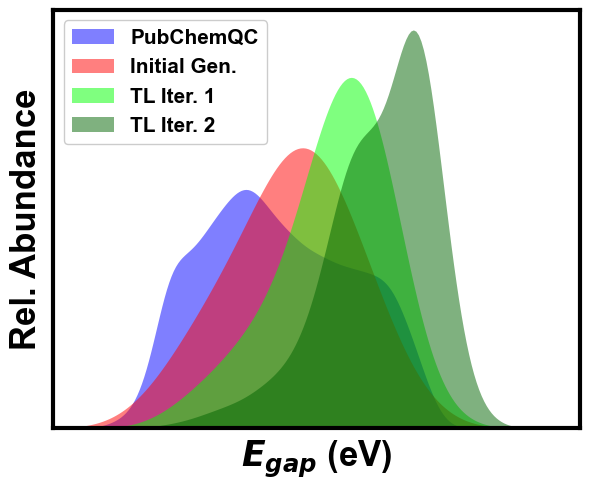

In [6]:
fig, ax = plt.subplots(figsize=(6, 5))

bw_adjust1 = 2
bw_adjust2 = 3
bw_adjust3 = 2
bw_adjust4 = 2

sns.kdeplot(y_original, bw_adjust=bw_adjust1, color='blue', 
            fill=True, label='PubChemQC', linewidth=0, alpha=0.5)
sns.kdeplot(initial_train['pred_gap'], color='red', fill=True,
            bw_adjust=bw_adjust2, label='Initial Gen.', linewidth=0, alpha=0.5)

sns.kdeplot(trans1['pred_gap'], color='lime', fill=True,
            bw_adjust=bw_adjust3, label='TL Iter. 1', linewidth=0, alpha=0.5)

sns.kdeplot(trans2['pred_gap'], color='darkgreen', fill=True, 
            bw_adjust=bw_adjust4, label='TL Iter. 2', linewidth=0, alpha=0.5)

plt.xlabel('d', fontsize=20,fontweight='bold', fontname='Arial')
plt.legend(fontsize=15, framealpha=1, loc='upper left')
plt.xlim(0, 14.5)

plt.xlabel(r'$E_{gap}$ (eV)', fontsize=25, 
           fontname='Arial', fontweight="bold", labelpad=0)
plt.ylabel('Rel. Abundance', fontsize=25, 
           fontname='Arial', fontweight="bold", labelpad=0)
plt.xlim(0, 14)
plt.xticks()
ax.tick_params(axis='both', which='major', labelsize=15, width=0, length=4)

[i.set_linewidth(3) for i in ax.spines.values()]
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.tight_layout()
plt.savefig('genVSpubqc_dist.jpeg', dpi=500)